In [6]:
!pip install mrmr_selection

from pandas import read_excel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

from mrmr import mrmr_classif

import sklearn
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, max_error
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, mean_absolute_percentage_error, d2_tweedie_score

In [7]:
df = pd.read_csv('/kaggle/input/secondary-school-result/Business Studies.csv') 
df.drop('Group SSC', axis=1, inplace=True)
df.head()

,Gender,Father Highest Academic Qualification,Mother Highest Academic Qualification,Father Profession,Mother Profession,Father average monthly income,Mother average monthly income,How many siblings do you have,District Currently you are living,PEC Result Overall GPA,...,PEC Science,JSC Overall GPA,JSC Bangla,JSC English,JSC Mathematics,JSC BGS,JSC ICT,JSC Religion,JSC Science,Overall GPA SSC
0,1,4,1,0,2,0,0,7,0,4.25,...,4.0,3.28,4.0,3.5,3.5,4.0,4.0,5.0,3.5,3.56
1,1,5,1,0,2,50000,0,4,0,5.00,...,5.0,5.00,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.00
2,1,4,2,1,2,30000,0,3,6,5.00,...,5.0,4.90,4.0,5.0,5.0,5.0,3.5,4.0,5.0,4.67
3,1,5,4,0,2,90000,0,1,5,5.00,...,5.0,5.00,5.0,5.0,4.0,5.0,5.0,5.0,5.0,4.68
4,1,1,0,1,2,100000,35000,7,4,4.55,...,5.0,5.00,4.0,5.0,4.0,5.0,5.0,5.0,5.0,4.55


In [8]:
df.shape

(110, 25)

In [9]:
df.corr()

,Gender,Father Highest Academic Qualification,Mother Highest Academic Qualification,Father Profession,Mother Profession,Father average monthly income,Mother average monthly income,How many siblings do you have,District Currently you are living,PEC Result Overall GPA,...,PEC Science,JSC Overall GPA,JSC Bangla,JSC English,JSC Mathematics,JSC BGS,JSC ICT,JSC Religion,JSC Science,Overall GPA SSC
Gender,1.000000,-0.081295,-0.107227,0.090355,-0.088419,0.093381,0.228239,0.154943,-0.036972,-0.161126,...,-0.153014,-0.097031,0.016578,-0.084379,-0.126242,-0.056928,-0.047837,0.022099,0.096596,-0.192225
Father Highest Academic Qualification,-0.081295,1.000000,0.683826,-0.271755,-0.171130,-0.052933,0.106863,-0.198084,-0.129379,0.236939,...,0.110079,0.186859,0.078415,0.170806,0.161183,0.205653,0.156833,0.135501,0.213394,0.141957
Mother Highest Academic Qualification,-0.107227,0.683826,1.000000,-0.238954,-0.329890,0.166602,0.181808,-0.341734,-0.098468,0.157870,...,0.085735,0.160065,0.119171,0.148674,0.109985,0.072761,0.156131,0.112948,0.088620,0.152090
Father Profession,0.090355,-0.271755,-0.238954,1.000000,0.111754,0.007282,0.067437,-0.020222,0.089230,-0.032259,...,-0.029677,-0.146424,-0.055802,-0.190883,-0.083285,-0.113753,-0.036680,-0.076913,-0.217849,-0.096282
Mother Profession,-0.088419,-0.171130,-0.329890,0.111754,1.000000,0.073690,-0.268414,0.111442,-0.236824,0.190539,...,0.166911,0.143468,0.123105,0.095287,0.211951,0.034677,0.099120,0.022976,0.079476,0.054157
Father average monthly income,0.093381,-0.052933,0.166602,0.007282,0.073690,1.000000,0.239253,0.102617,-0.190223,0.055319,...,0.064494,0.067324,0.035399,0.144795,0.175974,0.015359,0.160332,0.076073,0.133319,0.058652
Mother average monthly income,0.228239,0.106863,0.181808,0.067437,-0.268414,0.239253,1.000000,0.063808,-0.087582,0.031691,...,0.143073,0.095420,0.000915,0.196458,0.034069,0.158087,0.163914,0.096180,0.129885,0.088336
How many siblings do you have,0.154943,-0.198084,-0.341734,-0.020222,0.111442,0.102617,0.063808,1.000000,-0.131987,0.006333,...,-0.057889,-0.033289,-0.099346,0.010575,0.015602,-0.100828,-0.051858,0.083715,0.058046,-0.011914
District Currently you are living,-0.036972,-0.129379,-0.098468,0.089230,-0.236824,-0.190223,-0.087582,-0.131987,1.000000,-0.474890,...,-0.392319,-0.412657,-0.315494,-0.412267,-0.299997,-0.275815,-0.410724,-0.396826,-0.194846,-0.184819
PEC Result Overall GPA,-0.161126,0.236939,0.157870,-0.032259,0.190539,0.055319,0.031691,0.006333,-0.474890,1.000000,...,0.679669,0.767519,0.536527,0.664205,0.555825,0.519548,0.538811,0.522251,0.345772,0.767096


<AxesSubplot:>

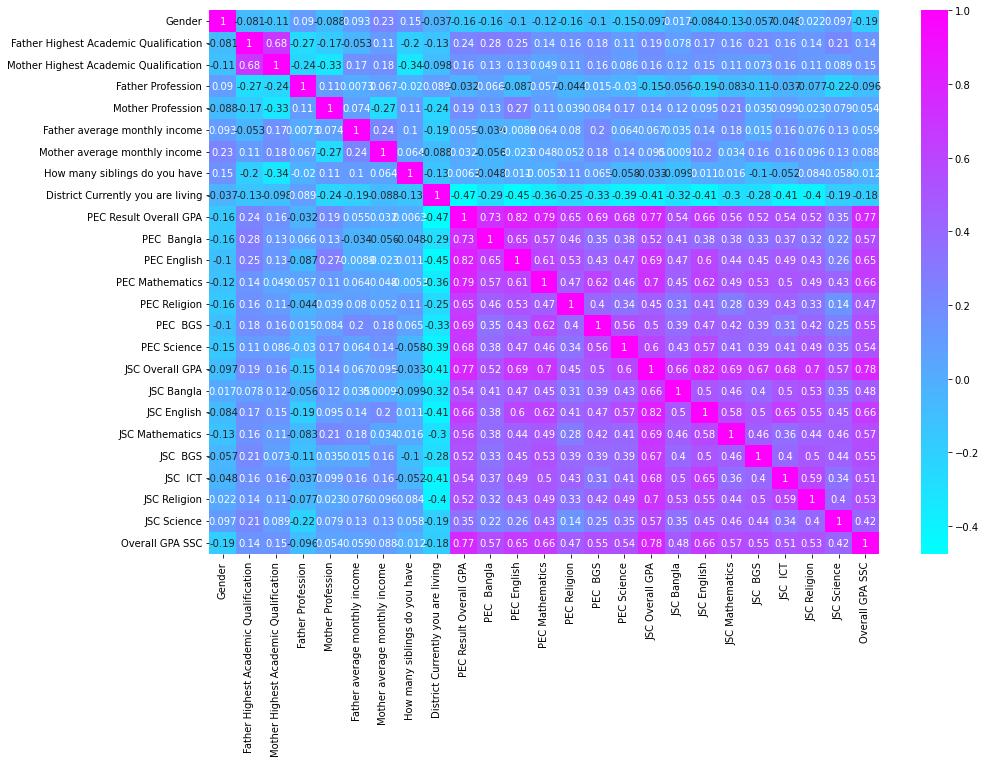

In [10]:
figure = plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True,cmap=plt.cm.cool)

In [11]:
X = df.drop(columns=['Overall GPA SSC'],axis=1)
y = df['Overall GPA SSC']

from sklearn.feature_selection import f_regression

# inputs:
#    X: pandas.DataFrame, features
#    y: pandas.Series, target variable
#    K: number of features to select

# compute F-statistics and initialize correlation matrix
F = pd.Series(f_regression(X, y)[0], index = X.columns)
corr = pd.DataFrame(.00001, index = X.columns, columns = X.columns)

In [12]:
# initialize list of selected features and list of excluded features
selected = []
not_selected = X.columns.to_list()
scores = []

K = 10
# repeat K times
for i in range(K):
  
    # compute (absolute) correlations between the last selected feature and all the (currently) excluded features
    if i > 0:
        last_selected = selected[-1]
        corr.loc[not_selected, last_selected] = X[not_selected].corrwith(X[last_selected]).abs().clip(.00001)
        
    # compute FCQ score for all the (currently) excluded features (this is Formula 2)
    score = F.loc[not_selected] / corr.loc[not_selected, selected].mean(axis = 1).fillna(.00001)
    
    # find best feature, add it to selected and remove it from not_selected
    if not i==0:
        scores.append(score)
    best = score.index[score.argmax()]
    selected.append(best)
    not_selected.remove(best)

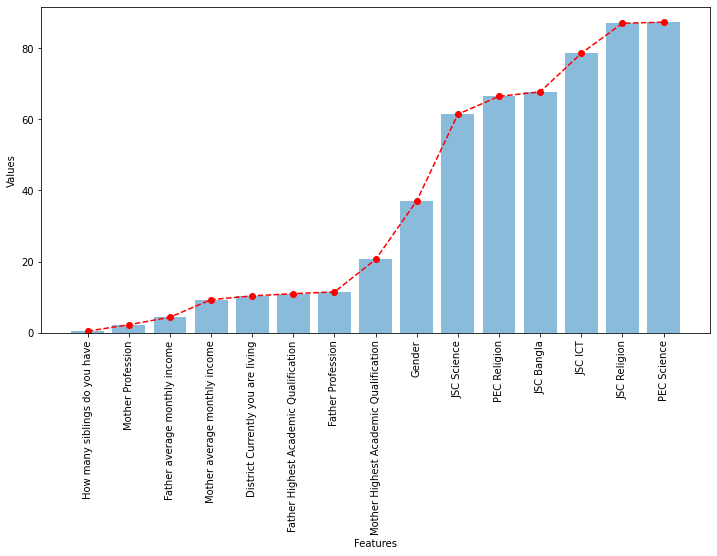

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

a = [
    ('Gender', 37.080157),
    ('Father Highest Academic Qualification', 10.996801),
    ('Mother Highest Academic Qualification', 20.609546),
    ('Father Profession', 11.492629),
    ('Mother Profession', 2.272063),
    ('Father average monthly income', 4.385158),
    ('Mother average monthly income', 9.318949),
    ('How many siblings do you have', 0.466453),
    ('District Currently you are living', 10.380747),
    ('PEC Religion', 66.427909),
    ('PEC Science', 87.278202),
    ('JSC Bangla', 67.701933),
    ('JSC ICT', 78.513125),
    ('JSC Religion', 86.978812),
    ('JSC Science', 61.416547)
]

# Sort the data in ascending order
sorted_data = sorted(a, key=lambda x: x[1])

# Extract features and values
features = [entry[0] for entry in sorted_data]
values = [entry[1] for entry in sorted_data]

# Set the color palette to "blues_d"
sns.set_palette("Blues_d")

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(features, values)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Values')
plt.plot(range(len(values)), values, 'r--', marker='o')  # Add lines connecting the bars
plt.show()

In [14]:
df.nunique()

Gender                                    2
Father Highest Academic Qualification     6
Mother Highest Academic Qualification     6
Father Profession                         3
Mother Profession                         3
Father average monthly income            34
Mother average monthly income            19
How many siblings do you have             9
District Currently you are living         8
PEC Result Overall GPA                   50
PEC  Bangla                               5
PEC English                               6
PEC Mathematics                           6
PEC Religion                              4
PEC  BGS                                  5
PEC Science                               5
JSC Overall GPA                          51
JSC Bangla                                5
JSC English                               6
JSC Mathematics                           5
JSC  BGS                                  5
JSC  ICT                                  5
JSC Religion                    

In [15]:
df.isnull().sum()

Gender                                   0
Father Highest Academic Qualification    0
Mother Highest Academic Qualification    0
Father Profession                        0
Mother Profession                        0
Father average monthly income            0
Mother average monthly income            0
How many siblings do you have            0
District Currently you are living        0
PEC Result Overall GPA                   0
PEC  Bangla                              0
PEC English                              0
PEC Mathematics                          0
PEC Religion                             0
PEC  BGS                                 0
PEC Science                              0
JSC Overall GPA                          0
JSC Bangla                               0
JSC English                              0
JSC Mathematics                          0
JSC  BGS                                 0
JSC  ICT                                 0
JSC Religion                             0
JSC Science

In [7]:
# X = df.drop(columns=['Overall GPA SSC'],axis=1)
# y = df['Overall GPA SSC']

# selected_features = mrmr_classif(X=X, y=y, K=10)
# X_mrmr = df[selected_features]
# X_mrmr = scale(X_mrmr)

100%|██████████| 10/10 [00:00<00:00, 40.08it/s]


In [24]:
X = df[selected]
y = df['Overall GPA SSC']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Metrics

In [29]:
l = []
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def metrics(model_name, y_pred_test_x):
    mean = mean_absolute_error(y_test, y_pred_test_x)
    rmse = mean_squared_error(y_test, y_pred_test_x, squared=False)
    r2 = r2_score(y_test, y_pred_test_x)
    explained_variance = explained_variance_score(y_test, y_pred_test_x, sample_weight=None, multioutput='uniform_average')
    max_error_ = max_error(y_test, y_pred_test_x)
    mean_poisson_deviance_ = mean_poisson_deviance(y_test, y_pred_test_x)
    mean_gamma_deviance_ = mean_gamma_deviance(y_test, y_pred_test_x)
    mean_absolute_percentage_error_ = mean_absolute_percentage_error(y_test, y_pred_test_x)
    d2_tweedie_score_ = d2_tweedie_score(y_test, y_pred_test_x)
    mape_ = mape(y_test, y_pred_test_x)
    
    print("Mean Absolute Error: ",mean )
    print("Mean Squared Error: ",rmse )
    print("R2 score: ",r2 )
    print("Explained Variance: ",explained_variance )
    print("max_error: ",max_error_ )
    print("neg_mean_poisson_deviance: ",mean_poisson_deviance_ )
    print("neg_mean_gamma_deviance: ",mean_gamma_deviance_ )
    print("neg_mean_absolute_percentage_error: ",mean_absolute_percentage_error_ )
    print("d2_tweedie_score: ",d2_tweedie_score_ )
    print("mape_: ", mape_)
    l.append([model_name, explained_variance, max_error_, mean, rmse, r2, mape_, mean_poisson_deviance_, mean_gamma_deviance_, mean_absolute_percentage_error_, d2_tweedie_score_])

In [30]:
from sklearn.inspection import permutation_importance

feature_names = ['Gender', 'F Edu', 'M Edu', 'F Prof', 'M Prof', 'F Avg Inc', 'M Avg Inc', 'Siblings', 'Distri','Pec Res Ov' ,'Pec Bangla','Pec English', 'Pec Math', 'Pec Reli', 'Pec BGS', 'Pec Sci', 'Jsc Res Ov','Jsc Bangla','Jsc english','Jsc Math','Jsc bgs','jsc ict','jsc reli', 'jsc sci']
features = np.array(feature_names)

def feature_importance(model):
    perm_importance = permutation_importance(model, X_test, y_test)
    sorted_idx = perm_importance.importances_mean.argsort()
    plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")

def predicted_plot(y_pred_test_x):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    from statsmodels.graphics.api import abline_plot
    ax[0].scatter(y_pred_test_x, y_test, color="black")
    abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
    ax[0].grid(True)
    ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
    ax[0].legend()
    plt.show()

### SVR

Mean Absolute Error:  0.3146559347617664
Mean Squared Error:  0.43916355887611364
R2 score:  0.328990971269156
Explained Variance:  0.3572688170418914
max_error:  1.4146141305149609
neg_mean_poisson_deviance:  0.04628072816875466
neg_mean_gamma_deviance:  0.011214891825383478
neg_mean_absolute_percentage_error:  0.07884906273167645
d2_tweedie_score:  0.328990971269156
mape_:  7.884906273167645


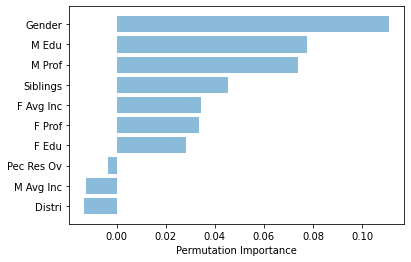

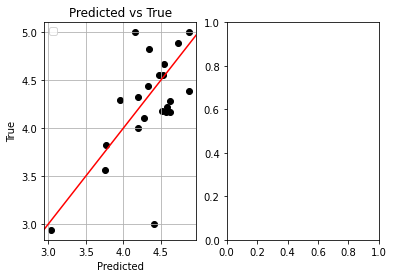

In [31]:
from sklearn.svm import SVR
svr = SVR(kernel = 'rbf')
svr.fit(X_train,y_train)

y_pred_test_x_svr = svr.predict(X_test)
metrics("SVR",y_pred_test_x_svr)
feature_importance(svr)
predicted_plot(y_pred_test_x_svr)

Mean Absolute Error:  0.3022937628533082
Mean Squared Error:  0.4186600894638037
R2 score:  0.3901838862141256
Explained Variance:  0.409255374846099
max_error:  1.4242999999999988
neg_mean_poisson_deviance:  0.0425407772559166
neg_mean_gamma_deviance:  0.010425020806283674
neg_mean_absolute_percentage_error:  0.07660596640504501
d2_tweedie_score:  0.3901838862141256
mape_:  7.660596640504501


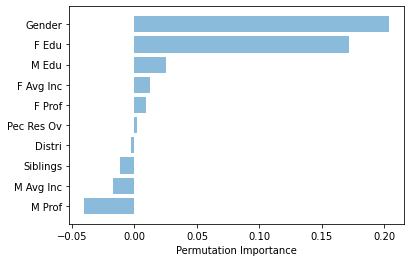

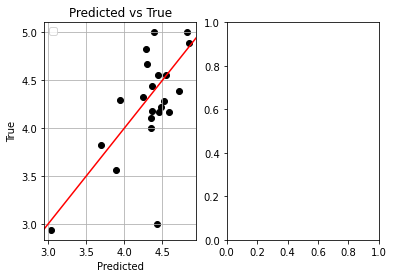

In [32]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
rf_regressor.fit(X_train,y_train)

y_pred_test_x_rf = rf_regressor.predict(X_test)
metrics("Random Forest",y_pred_test_x_rf)
feature_importance(rf_regressor)
predicted_plot(y_pred_test_x_rf)

Mean Absolute Error:  0.3015792287024563
Mean Squared Error:  0.403589967216931
R2 score:  0.4332957163579181
Explained Variance:  0.45405663409925323
max_error:  1.3250099780716678
neg_mean_poisson_deviance:  0.03968115164906306
neg_mean_gamma_deviance:  0.009769404480567663
neg_mean_absolute_percentage_error:  0.07580747948001777
d2_tweedie_score:  0.4332957163579181
mape_:  7.580747948001777


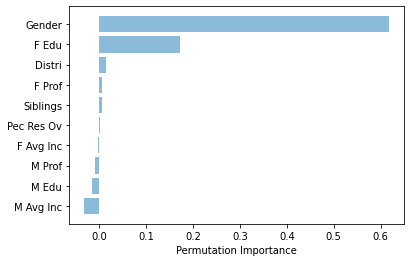

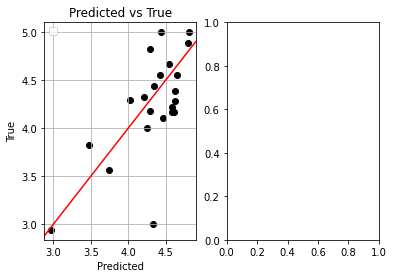

In [33]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

y_pred_test_x_lr = lr.predict(X_test)
metrics("Linear Regression",y_pred_test_x_lr)
feature_importance(lr)
predicted_plot(y_pred_test_x_lr)

Mean Absolute Error:  0.27142378459401756
Mean Squared Error:  0.4013905381480806
R2 score:  0.43945557996079465
Explained Variance:  0.46487668505476143
max_error:  1.3999999999999995
neg_mean_poisson_deviance:  0.03925856246791055
neg_mean_gamma_deviance:  0.009658754484909281
neg_mean_absolute_percentage_error:  0.06927295081755519
d2_tweedie_score:  0.43945557996079465
mape_:  6.927295081755519


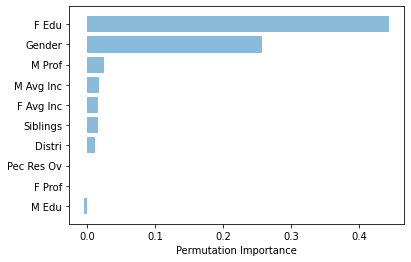

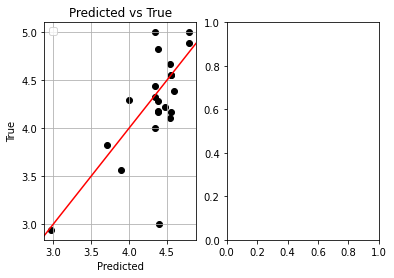

In [34]:
from sklearn.ensemble import AdaBoostRegressor
ADA = AdaBoostRegressor(n_estimators=5, random_state=42)
ADA.fit(X_train, y_train)

y_pred_test_x_ada = ADA.predict(X_test)
metrics("ADA Boost Regressor",y_pred_test_x_ada)
feature_importance(ADA)
predicted_plot(y_pred_test_x_ada)

Mean Absolute Error:  0.3078271631761031
Mean Squared Error:  0.4208648316869051
R2 score:  0.38374416325499505
Explained Variance:  0.40469404512505613
max_error:  1.3929119110107422
neg_mean_poisson_deviance:  0.04291070033752551
neg_mean_gamma_deviance:  0.010493345763251187
neg_mean_absolute_percentage_error:  0.07739301213792803
d2_tweedie_score:  0.38374416325499494
mape_:  7.739301213792802


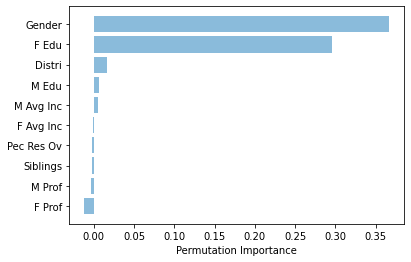

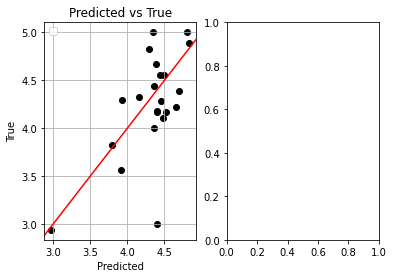

In [35]:
import xgboost
XG = xgboost.XGBRFRegressor()
XG.fit(X_train, y_train)

y_pred_test_x_XG = XG.predict(X_test)
metrics("XGBoost",y_pred_test_x_XG)
feature_importance(XG)
predicted_plot(y_pred_test_x_XG)

Mean Absolute Error:  0.3532565870584769
Mean Squared Error:  0.4552525594609923
R2 score:  0.27892479123853
Explained Variance:  0.34989580318110614
max_error:  0.9950779470967785
neg_mean_poisson_deviance:  0.04953240325480996
neg_mean_gamma_deviance:  0.012265018663258303
neg_mean_absolute_percentage_error:  0.08918830698882597
d2_tweedie_score:  0.27892479123853
mape_:  8.918830698882598


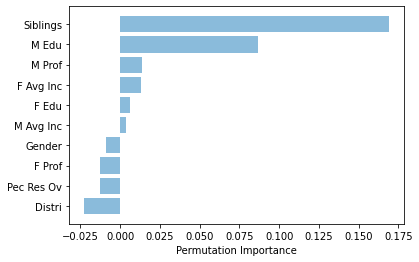

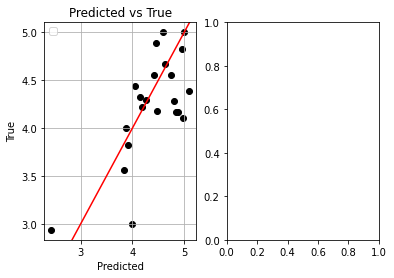

In [36]:
from sklearn.neural_network import MLPRegressor
MLP = MLPRegressor(random_state=42, max_iter=2000)
MLP.fit(X_train, y_train)

y_pred_test_x_MLP = MLP.predict(X_test)
metrics("MLP",y_pred_test_x_MLP)
feature_importance(MLP)
predicted_plot(y_pred_test_x_MLP)

Mean Absolute Error:  0.33965709409007616
Mean Squared Error:  0.46262176972541397
R2 score:  0.25539164766956646
Explained Variance:  0.2707586664193681
max_error:  1.3421815236421244
neg_mean_poisson_deviance:  0.053333983457092705
neg_mean_gamma_deviance:  0.01345255423675007
neg_mean_absolute_percentage_error:  0.0883893563586899
d2_tweedie_score:  0.25539164766956635
mape_:  8.83893563586899


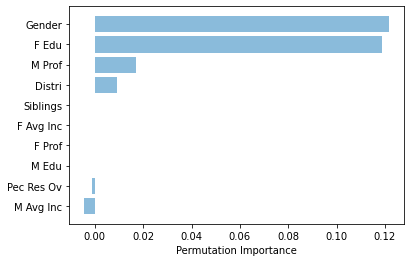

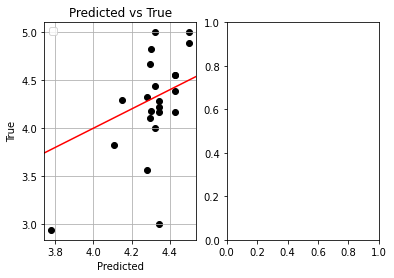

In [37]:
from sklearn.ensemble import GradientBoostingRegressor
GRADIENT = GradientBoostingRegressor(n_estimators=5, random_state=42)
GRADIENT.fit(X_train, y_train)

y_pred_test_x_GRADIENT = GRADIENT.predict(X_test)
metrics("GRADIENT",y_pred_test_x_GRADIENT)
feature_importance(GRADIENT)
predicted_plot(y_pred_test_x_GRADIENT)

In [38]:
estimator=[]
for i in range(1, 30):
    model = GradientBoostingRegressor(n_estimators=i, random_state=42)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test) 
    estimator.append(score)
    
(estimator.index(max(estimator)))+1

16

Mean Absolute Error:  0.3044088022153064
Mean Squared Error:  0.40773992861855024
R2 score:  0.42158139028324715
Explained Variance:  0.45964390994391924
max_error:  1.32528675882594
neg_mean_poisson_deviance:  0.04084277353447486
neg_mean_gamma_deviance:  0.010152013485269628
neg_mean_absolute_percentage_error:  0.07797569733653952
d2_tweedie_score:  0.42158139028324715
mape_:  7.797569733653951


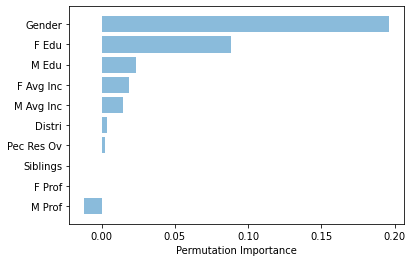

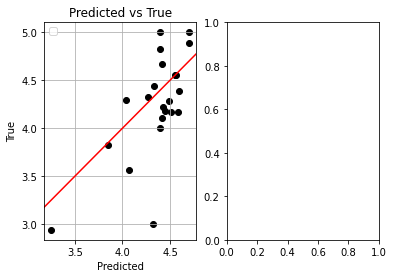

In [39]:
from sklearn.ensemble import GradientBoostingRegressor
GRADIENT = GradientBoostingRegressor(n_estimators= 17, random_state=42)
GRADIENT.fit(X_train, y_train)

y_pred_test_x_GRADIENT = GRADIENT.predict(X_test)
metrics("Optimized GRADIENT",y_pred_test_x_GRADIENT)
feature_importance(GRADIENT)
predicted_plot(y_pred_test_x_GRADIENT)

Mean Absolute Error:  0.3559545454545453
Mean Squared Error:  0.44080788435450063
R2 score:  0.32395675189197926
Explained Variance:  0.4328997236790656
max_error:  1.2509999999999994
neg_mean_poisson_deviance:  0.04709185801920166
neg_mean_gamma_deviance:  0.011561826691610615
neg_mean_absolute_percentage_error:  0.09089398534833303
d2_tweedie_score:  0.32395675189197926
mape_:  9.089398534833302


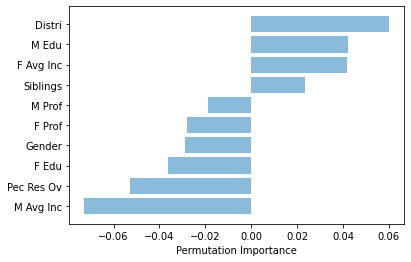

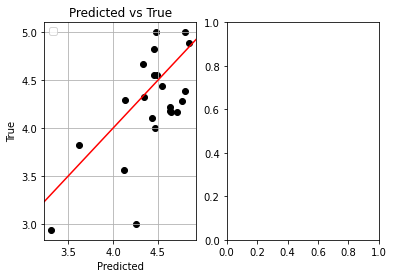

In [40]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

y_pred_test_x_knn = knn.predict(X_test)
metrics("KNN",y_pred_test_x_knn)
feature_importance(knn)
predicted_plot(y_pred_test_x_knn)

In [41]:
df = pd.DataFrame(l, columns=["model_name", "explained_variance", "max_error", "mean", "rmse", "r2","mape", "mean_poisson_deviance", "mean_gamma_deviance", "mean_absolute_percentage_error", "d2_tweedie_score"])
df

,model_name,explained_variance,max_error,mean,rmse,r2,mape,mean_poisson_deviance,mean_gamma_deviance,mean_absolute_percentage_error,d2_tweedie_score
0,SVR,0.357269,1.414614,0.314656,0.439164,0.328991,7.884906,0.046281,0.011215,0.078849,0.328991
1,Random Forest,0.409255,1.424300,0.302294,0.418660,0.390184,7.660597,0.042541,0.010425,0.076606,0.390184
2,Linear Regression,0.454057,1.325010,0.301579,0.403590,0.433296,7.580748,0.039681,0.009769,0.075807,0.433296
3,ADA Boost Regressor,0.464877,1.400000,0.271424,0.401391,0.439456,6.927295,0.039259,0.009659,0.069273,0.439456
4,XGBoost,0.404694,1.392912,0.307827,0.420865,0.383744,7.739301,0.042911,0.010493,0.077393,0.383744
5,MLP,0.349896,0.995078,0.353257,0.455253,0.278925,8.918831,0.049532,0.012265,0.089188,0.278925
6,GRADIENT,0.270759,1.342182,0.339657,0.462622,0.255392,8.838936,0.053334,0.013453,0.088389,0.255392
7,Optimized GRADIENT,0.459644,1.325287,0.304409,0.407740,0.421581,7.797570,0.040843,0.010152,0.077976,0.421581
8,KNN,0.432900,1.251000,0.355955,0.440808,0.323957,9.089399,0.047092,0.011562,0.090894,0.323957


In [43]:
# import shap library
import shap

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(rf_regressor)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train[0])

In [ ]:
import lime
import lime.lime_tabular
# LIME has one explainer for all the models
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names= feature_names,
                                                  class_names=['MEDV'], verbose=True, mode='regression')

In [ ]:
j = 5
exp = explainer.explain_instance(X_test[j], rf_regressor.predict, num_features=6)

# Show the predictions
exp.show_in_notebook(show_table=True)

In [ ]:
j = 7
exp = explainer.explain_instance(X_test[j], rf_regressor.predict, num_features=6)

# Show the predictions
exp.show_in_notebook(show_table=True)

In [ ]:
j = 16
exp = explainer.explain_instance(X_test[j], rf_regressor.predict, num_features=6)

# Show the predictions
exp.show_in_notebook(show_table=True)

In [ ]:
test = y_test
test = test.to_numpy()

In [ ]:
for i in range(10,15):
    exp = explainer.explain_instance(X_test[i], rf_regressor.predict, num_features=6)
    print("Y True: ", test[i])
    # Show the predictions
    exp.show_in_notebook(show_table=True)